#Predict the destination of taxi trips based on initial partial trajectories

The dataset for training is quite large. It is encoded as a csv file containing >1 million taxi rides for a 1 year duration in the city of Porto, Portugal. The most important field is the POLYLINE field, which contains a list of points (lat/lon), which are the updated location of the cab every 15 seconds for the duration of the ride. The test data contains a truncated POLYLINE, which will be used to predict the destination of the cab. Competition details here https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i.

In [257]:
%matplotlib inline
from __future__ import division
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

rng = np.random.RandomState(1)

In [66]:
taxi_train = pd.read_csv('train.csv', chunksize=1000)
type(taxi_train) #returns a chunkable TextFileReader that can iterate with chunksize, or by its read(nrows) method

pandas.io.parsers.TextFileReader

In [30]:
plengths = []
for chunk in taxi_train:
    chunk = chunk.replace(to_replace=True, value=np.nan).dropna(subset=['MISSING_DATA'])
    chunk.POLYLINE = chunk.POLYLINE.apply(eval)
    for p in chunk.POLYLINE:
        plengths.append(len(p))

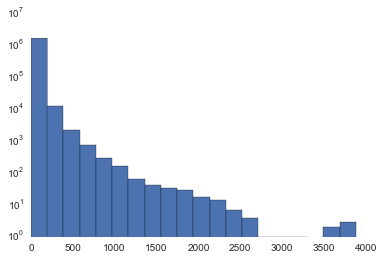

In [57]:
plengths = np.array(plengths)
sns.plt.hist(plengths, 20)
sns.plt.yscale('log')

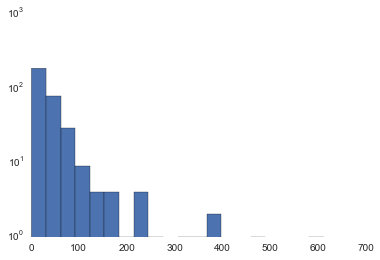

In [58]:
taxi_test = pd.read_csv('test.csv')
taxi_test.POLYLINE = taxi_test.POLYLINE.apply(eval)
test_plengths = [len(p) for p in taxi_test.POLYLINE]
sns.plt.hist(test_plengths, 20)
sns.plt.yscale('log')

In [344]:
min(test_plengths)

1

Comparing the test and train data you can see that there is a much larger range of POLYLINE lengths in the training data than the test data. In the training data you have POLYLINES as long as 4000 coordinates. If the data are being collected every 15 seconds as indicated on the kaggle site, then that would be a 16 hour cab ride, which is obviously very unlikely. Since these are large outliers my guess is that the cab driver either forgot to somehow end the GPS transmission and left it going overnight, or something like that. It is surprising however, how many POLYLINES have lengths in the 1000 - 2000 range since these would still be many hour long cab rides. It may be that the collection of coordinates is not actually every 15 seconds, but variable. In any case, it is clear that in order to make most effective use of the data whatever algorithm is used to predict the destination must be able to accomodate varying amounts of training data from the POLYLINE feature. One possibility might be to smooth the data using a filter, such as a Kalman or Bayesian filter and then represent the trajectory as a parameterized Bezier (or polynomial) curve, such that curves most closely matching previously seen curves are predicted to have similar destinations.

###Model scoring

The scoring of the model will require calculating the distance between the predicted point and ground truth destination. In the kaggle competition the distance is not the simple euclidian distance between two points on a plane, but the Havershine distance, which is calculated on the surface of a sphere, with the radius (in kilometers) set to that of earth.

<img src='mean_hav.png'>

In [267]:
def kaggle_haversine(coord1, coord2, r = 6371.0):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    lat = abs(lat1-lat2)*np.pi/180
    lon = abs(lon1-lon2)*np.pi/180
    lat1 = lat1*np.pi/180
    lat2 = lat2*np.pi/180
    a = np.sin(lat/2)*np.sin(lat/2)+np.cos(lat1)*np.cos(lat2)*np.sin(lon/2)*np.sin(lon/2)
    d = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = r*d
    return(d)


###Basic model with Multitask Lasso

In [156]:
from sklearn.linear_model import MultiTaskElasticNet, MultiTaskLasso, MultiTaskElasticNetCV, MultiTaskLassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.cross_validation import KFold, cross_val_score

In [104]:
import re
def f(cell):
    match = re.search(r'^\[\[.*\]\]$', cell)
    if match:
        return np.array(eval(cell))
    else:
        return np.nan

In [105]:
df = taxi_train.read(5000)
df.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA
count,5.000000e+03,1052.000000,2733.000000,5000.000000,5.000000e+03,5000
mean,1.592368e+15,23167.331749,29.866813,20000347.894800,1.374030e+09,0
std,3.299421e+13,19657.867698,17.809361,209.193492,3.299431e+04,0
min,1.373755e+18,2001.000000,1.000000,20000001.000000,1.373755e+09,False
25%,1.373998e+18,5640.000000,15.000000,20000163.000000,1.373998e+09,0
50%,1.374041e+18,16168.000000,26.000000,20000344.000000,1.374041e+09,0
75%,1.374059e+18,38577.000000,47.000000,20000518.000000,1.374059e+09,0
max,1.374079e+18,63882.000000,63.000000,20000904.000000,1.374079e+09,False


In [106]:
df.POLYLINE = df.POLYLINE.apply(f)

In [110]:
df.dropna(axis = 'rows', subset = ['POLYLINE'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4972 entries, 0 to 4999
Data columns (total 9 columns):
TRIP_ID         4972 non-null int64
CALL_TYPE       4972 non-null object
ORIGIN_CALL     1050 non-null float64
ORIGIN_STAND    2724 non-null float64
TAXI_ID         4972 non-null int64
TIMESTAMP       4972 non-null int64
DAY_TYPE        4972 non-null object
MISSING_DATA    4972 non-null bool
POLYLINE        4972 non-null object
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 354.4+ KB


In [111]:
df.fillna(value = 0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4972 entries, 0 to 4999
Data columns (total 9 columns):
TRIP_ID         4972 non-null int64
CALL_TYPE       4972 non-null object
ORIGIN_CALL     4972 non-null float64
ORIGIN_STAND    4972 non-null float64
TAXI_ID         4972 non-null int64
TIMESTAMP       4972 non-null int64
DAY_TYPE        4972 non-null object
MISSING_DATA    4972 non-null bool
POLYLINE        4972 non-null object
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 354.4+ KB


In [220]:
X = df.drop(['POLYLINE', 'TRIP_ID', 'MISSING_DATA'], axis = 'columns')
X = pd.get_dummies(X, columns=['CALL_TYPE', 'DAY_TYPE'])

def trunc_plines(cell): 
    '''Truncate trajectories to roughly half their total length, 
    unless they are too short, then deal with them by doing nothing or repeat the origin twice.'''
    len_cell = len(cell)
    if len_cell > 2:
        ret_cell = np.vstack((cell[:(len_cell//2)+1, :], np.atleast_2d(cell[-1])))
        return ret_cell
    elif len_cell == 1:
        ret_cell = np.vstack((cell, cell))
        return ret_cell
    else:
        return cell

plines = df.POLYLINE.apply(trunc_plines)
ori = np.array([k[0] for k in plines])
midp = np.array([i[-2] for i in plines])
dest = [j[-1] for j in plines]
X['MID_LAT'] = midp[:,0]
X['MID_LON'] = midp[:,1]
X['ORI_LAT'] = ori[:,0]
X['ORI_LON'] = ori[:,1]
y = np.array(dest).reshape((-1,2))
X = X.values

At this point I am limited to algorithms that are capable of multi-output prediction. These include decision trees and a form of linear regression called Multitask Lasso. Below are a few examples to see how close they each come using a small subset of the data.

###Decision Tree Regressor

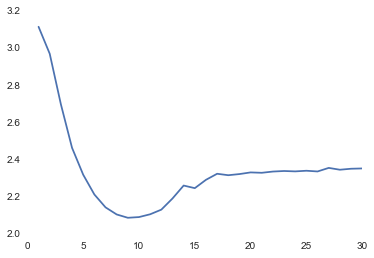

In [263]:
kf = KFold(len(X), n_folds=8, shuffle=True, random_state=1)
mean_scores_all = []
for d in range(1,31):
    reg = DecisionTreeRegressor(max_depth=d, random_state=1)
    mean_scores = []
    for train, test in kf:
        scores = []
        reg.fit(X[train], y[train])
        preds = reg.predict(X[test])
        for i,j in zip(preds,y[test]):
            score = kaggle_haversine(i,j)
            scores.append(score)
        mean_scores.append(np.mean(scores))
    mean_scores_all.append(np.mean(mean_scores))

sns.plt.plot(range(1,31), mean_scores_all)

In [264]:
print min(mean_scores_all), range(1,31)[np.argmin(mean_scores_all)]

2.09154285061 9


###Extra Trees

1.65452698315 19


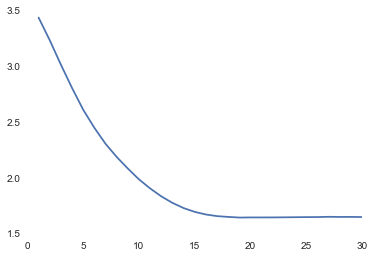

In [265]:
kf = KFold(len(X), n_folds=8, shuffle=True, random_state=1)
mean_scores_all = []
for d in range(1,31):
    reg = ExtraTreesRegressor(n_estimators=1000, max_depth=d, random_state=1)
    mean_scores = []
    for train, test in kf:
        scores = []
        reg.fit(X[train], y[train])
        preds = reg.predict(X[test])
        for i,j in zip(preds,y[test]):
            score = kaggle_haversine(i,j)
            scores.append(score)
        mean_scores.append(np.mean(scores))
    mean_scores_all.append(np.mean(mean_scores))
print min(mean_scores_all), range(1,31)[np.argmin(mean_scores_all)]

sns.plt.plot(range(1,31), mean_scores_all)

###Random Forest

In [266]:
kf = KFold(len(X), n_folds=8, shuffle=True)
reg = RandomForestRegressor(n_estimators=1000, max_depth=19, n_jobs=-1)
mean_scores = []
for train, test in kf:
    scores = []
    reg.fit(X[train], y[train])
    preds = reg.predict(X[test])
    for i,j in zip(preds,y[test]):
        score = kaggle_haversine(i,j)
        scores.append(score)
    mean_scores.append(np.mean(scores))
print mean_scores, np.mean(mean_scores)

[1.5901252070083383, 1.6477313718050925, 1.6987410515441497, 1.5476911694575619, 1.6444965081609146, 1.6093270984171644, 1.6472617590623053, 1.913638740996445] 1.66237661331


###Multitask Lasso

In [211]:
kf = KFold(len(X), n_folds=7, shuffle=True)
reg = MultiTaskLassoCV(normalize=True, cv = 5, n_jobs = -1)
mean_scores = []
for train, test in kf:
    scores = []
    reg.fit(X[train], y[train])
    preds = reg.predict(X[test])
    for i,j in zip(preds,y[test]):
        score = kaggle_haversine(i,j)
        scores.append(score)
    mean_scores.append(np.mean(scores))
print mean_scores, np.mean(mean_scores)

[1.8348951987821531, 1.859510468503125, 1.7879350904602314, 1.9078473661046749, 2.0739303539308787, 1.9121935011854447, 1.7968780834055729] 1.88188429462


###Multitask ElasticNet

In [212]:
kf = KFold(len(X), n_folds=7, shuffle=True)
reg = MultiTaskElasticNetCV(normalize=True, cv = 5, n_jobs = -1)
mean_scores = []
for train, test in kf:
    scores = []
    reg.fit(X[train], y[train])
    preds = reg.predict(X[test])
    for i,j in zip(preds,y[test]):
        score = kaggle_haversine(i,j)
        scores.append(score)
    mean_scores.append(np.mean(scores))
print mean_scores, np.mean(mean_scores)

[1.8895161821619983, 1.8600904066409412, 1.8536442799234816, 1.9788844415030942, 1.9015624062007144, 1.9314519857534911, 1.7681248006517702] 1.88332492898


So far the best results are using a Extra Trees, although Random Forest is in the same ballpark.

###KNN

In [183]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor

In [213]:
kf = KFold(len(X), n_folds=7, shuffle=True)
mean_scores_all = []
for n in range(1,100):
    reg = KNeighborsRegressor(n)
    mean_scores = []
    for train, test in kf:
        scores = []
        reg.fit(X[train], y[train])
        preds = reg.predict(X[test])
        for i,j in zip(preds,y[test]):
            score = kaggle_haversine(i,j)
            scores.append(score)
        mean_scores.append(np.mean(scores))
    mean_scores_all.append(np.mean(mean_scores))

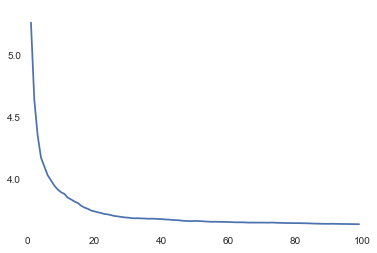

In [214]:
sns.plt.plot(range(1,100), mean_scores_all)

In [219]:
print min(mean_scores_all), range(1,100)[np.argmin(mean_scores_all)]

3.64530296312 99


KNN isn't so great. It's surprising that the prediction quality still gets better with increasing numbers of neighbors. I did this search with up to 1000 neighbors and it seemed to be getting asymptotically better. There must be something off about this.

At this point I will begin using a larger subset of the data to see how more training examples affects the results. I can also submit my data on the test samples to the kaggle site to see how they compare, however I'm not at that point yet. In addition, I would like to try a few other things, such as initially clustering the data and looking at how they separate. It would be interesting to try clustering and then running separate regressors on the clusters to see how well they each behave when trained on "like" samples. Perhaps a certain subset of these samples are easier to predict.

###t-SNE manifold dimensionality reduction/clustering

In [268]:
from sklearn.manifold import TSNE

In [270]:
tsne = TSNE(random_state=1)
X_tsne = tsne.fit_transform(X)

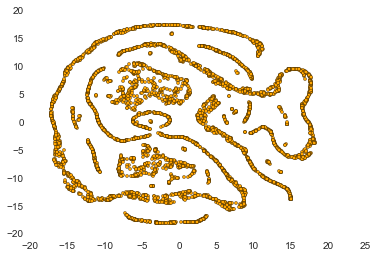

In [278]:
sns.plt.scatter(X_tsne[:,0], X_tsne[:,1], c = 'orange', s = 10)

In [289]:
from sklearn.cluster import SpectralClustering

In [315]:
clust = SpectralClustering(n_clusters=4, random_state=1)

In [316]:
X_specs_lab = clust.fit_predict(X)

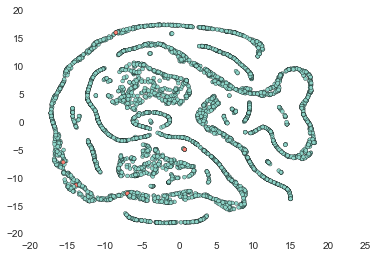

In [328]:
fig, ax = sns.plt.subplots()
pal = sns.color_palette('Set3', len(np.unique(X_specs_lab)))
sns.plt.scatter(X_tsne[:,0], X_tsne[:,1], c = [pal[i] for i in X_specs_lab], s = 15)

Not much interesting here. The clustering doesn't help much with the visualization. While the t-SNE representation is intriguing and suggestive of linear relationships within the data, it does not break down into obvious clusters. There are two possible clusters within the center of the t-SNE graph however it is difficult to interpret these in higher dimensional space. The next step is really just to add more data to the training set and see how that affects the predictions.

UPDATE:
The plot above may actually be hinting at the layout of the city of Porto, which has a large highway that surrounds it and many smaller internal roads.
<img src=http://upload.wikimedia.org/wikipedia/commons/c/c3/VCI.svg width=30% height=30% style='float:left'>

###Use more data

In [329]:
taxi_full = pd.read_csv('train.csv')
print taxi_full.info()
taxi_full.POLYLINE = taxi_full.POLYLINE.apply(f)
taxi_full.dropna(axis = 'rows', subset = ['POLYLINE'], inplace = True)
print taxi_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
TRIP_ID         int64
CALL_TYPE       object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID         int64
TIMESTAMP       int64
DAY_TYPE        object
MISSING_DATA    bool
POLYLINE        object
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 119.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704769 entries, 0 to 1710669
Data columns (total 9 columns):
TRIP_ID         int64
CALL_TYPE       object
ORIGIN_CALL     float64
ORIGIN_STAND    float64
TAXI_ID         int64
TIMESTAMP       int64
DAY_TYPE        object
MISSING_DATA    bool
POLYLINE        object
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 118.7+ MB
None


In [339]:
taxi_full.fillna(value = 0, inplace=True)
X_full = taxi_full.drop(['POLYLINE', 'TRIP_ID', 'MISSING_DATA'], axis = 'columns')
X_full = pd.get_dummies(X_full, columns=['CALL_TYPE', 'DAY_TYPE'])

def trunc_plines(cell): 
    '''Truncate trajectories to roughly half their total length, 
    unless they are too short, then deal with them by doing nothing or repeat the origin twice.'''
    len_cell = len(cell)
    if len_cell > 2:
        ret_cell = np.vstack((cell[:(len_cell//2)+1, :], np.atleast_2d(cell[-1])))
        return ret_cell
    elif len_cell == 1:
        ret_cell = np.vstack((cell, cell))
        return ret_cell
    else:
        return cell

plines_full = taxi_full.POLYLINE.apply(trunc_plines)
ori_full = np.array([k[0] for k in plines_full])
midp_full = np.array([i[-2] for i in plines_full])
dest_full = [j[-1] for j in plines_full]
X_full['MID_LAT'] = midp_full[:,0]
X_full['MID_LON'] = midp_full[:,1]
X_full['ORI_LAT'] = ori_full[:,0]
X_full['ORI_LON'] = ori_full[:,1]
y_full = np.array(dest_full).reshape((-1,2))
X_full = X_full.values

In [333]:
import itertools, gc

In [342]:
kf = KFold(len(X_full), n_folds=10, random_state=1)
mean_scores_full = []
reg = ExtraTreesRegressor(n_estimators=1000, max_depth=19, random_state=1, n_jobs = -1)
for train, test in kf:
    scores = []
    reg.fit(X_full[train], y_full[train])
    preds = reg.predict(X_full[test])
    for i,j in itertools.izip(preds,y_full[test]):
        score = kaggle_haversine(i,j)
        scores.append(score)
    mean_scores_full.append(np.mean(scores))
print mean_scores_full

[2.2593086801180591, 2.2291029424634057, 2.2181322398752177, 2.199430291498345, 2.1571248063929027, 2.1654767608870671, 2.153372522761146, 2.1850453508167855, 2.2557341604768144, 2.2822981329753764]


In [343]:
np.mean(mean_scores_full)

2.210502588826512

Compared to the kaggle scores this is actually pretty good. Just as a first pass I'll submit results based on the last regressor that was trained in the above loop and see how they do on the leaderboard...

In [348]:
taxi_test = pd.read_csv('test.csv')
print taxi_test.info()
taxi_test.POLYLINE = taxi_test.POLYLINE.apply(f)
taxi_test.dropna(axis = 'rows', subset = ['POLYLINE'], inplace = True)

taxi_test.fillna(value = 0, inplace=True)
print '\n',taxi_test.info()

trip_ID = taxi_test.TRIP_ID
X_test = taxi_test.drop(['POLYLINE', 'TRIP_ID', 'MISSING_DATA'], axis = 'columns')
X_test = pd.get_dummies(X_test, columns=['CALL_TYPE', 'DAY_TYPE'])

plines_test = taxi_test.POLYLINE.apply(trunc_plines)
ori_test = np.array([k[0] for k in plines_test])
midp_test = np.array([i[-2] for i in plines_test])
dest_test = [j[-1] for j in plines_test]
X_test['MID_LAT'] = midp_test[:,0]
X_test['MID_LON'] = midp_test[:,1]
X_test['ORI_LAT'] = ori_test[:,0]
X_test['ORI_LON'] = ori_test[:,1]
y_test = np.array(dest_test).reshape((-1,2))
X_test = X_test.values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 9 columns):
TRIP_ID         320 non-null object
CALL_TYPE       320 non-null object
ORIGIN_CALL     72 non-null float64
ORIGIN_STAND    123 non-null float64
TAXI_ID         320 non-null int64
TIMESTAMP       320 non-null int64
DAY_TYPE        320 non-null object
MISSING_DATA    320 non-null bool
POLYLINE        320 non-null object
dtypes: bool(1), float64(2), int64(2), object(4)
memory usage: 22.8+ KB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320 entries, 0 to 319
Data columns (total 9 columns):
TRIP_ID         320 non-null object
CALL_TYPE       320 non-null object
ORIGIN_CALL     320 non-null float64
ORIGIN_STAND    320 non-null float64
TAXI_ID         320 non-null int64
TIMESTAMP       320 non-null int64
DAY_TYPE        320 non-null object
MISSING_DATA    320 non-null bool
POLYLINE        320 non-null object
dtypes: bool(1), float64(2), int64(2), object(4)
memory usage: 22.8+ KB

In [349]:
preds = reg.predict(X_test)

In [357]:
with open('submission.csv', 'w') as sub:
    sub.write('"TRIP_ID","LATITUDE","LONGITUDE"\n')
    for c in itertools.izip(trip_ID,preds):
        write = '"{}",{:.6f},{:.6f}\n'.format(c[0],c[1][1],c[1][0])
        sub.write(write)

With my submission evaluated on Kaggle my results are given a score of about 3.519, which is significantly higher deviation than I saw with cross-validation. Perhaps the test set is known to be a difficult set of predictions to make?